In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
def preprocess_image(image):
    image = image.type(torch.float32)
    image = image / 255.
    return image

In [4]:
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda image: preprocess_image(image)),
    transforms.Resize((128, 128))
])

In [5]:
food101_ds = torchvision.datasets.Food101(root='./data/', download=False, transform=transform)

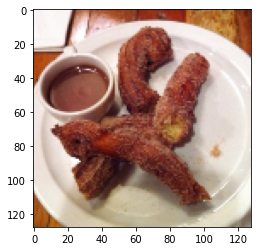

In [6]:
plt.imshow(food101_ds[0][0].permute(1, 2, 0))

In [7]:
food101_dl = torch.utils.data.DataLoader(food101_ds, batch_size=8, shuffle=False)

In [8]:
next_foods = next(iter(food101_dl))[0]

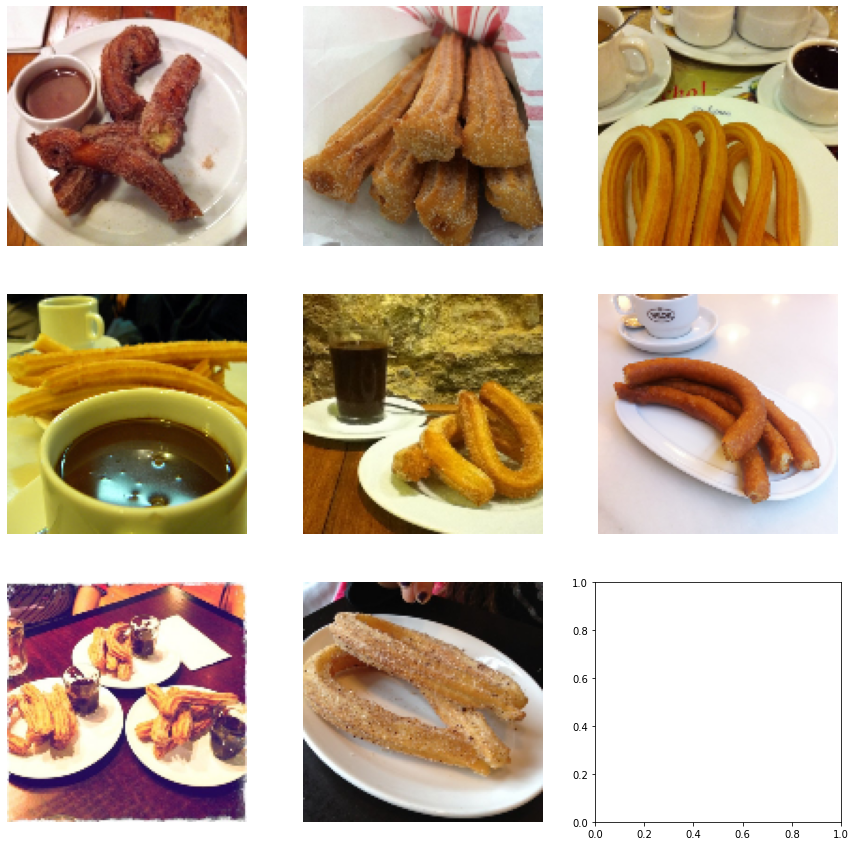

In [22]:
row = 0
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(next_foods.shape[0]):
    if i % 3 == 0 and i != 0:
        row += 1
    ax[row, i % 3].imshow(next_foods[i].permute(1, 2, 0))
    ax[row, i % 3].axis('off')

In [10]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):  
        super().__init__()
        
        self.res_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, out_channels, 3, padding=1),
        )
        
    def forward(self, x):
        return x + self.res_block(x)
    
class ResidualStack(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, num_residuals):
        super().__init__()
        
        self.num_residuals = num_residuals
        self.res_stack = nn.Sequential()
        
        for _ in range(num_residuals):
            self.res_stack.append(Residual(in_channels, out_channels, hidden_channels))
        
    def forward(self, x):
        return self.res_stack(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 4, 2, padding=1)
        self.conv2 = nn.Conv2d(256, 256, 4, 2, padding=1)
        
        self.res_stack = ResidualStack(256, 256, 256, 3)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        res1 = self.res_stack(x)
        res2 = self.res_stack(x)
        res3 = self.res_stack(x)
        
        return res1 + res2 + res3
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_transpose1 = nn.ConvTranspose2d(256, 256, 4, 2, padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(256, 3, 4, 2, padding=1)
        
        self.res_stack = ResidualStack(256, 256, 256, 3)
    
    def forward(self, x):     
        res1 = self.res_stack(x)
        res2 = self.res_stack(x)
        res3 = self.res_stack(x)
        
        x = res1 + res2 + res3
        
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        return x

In [11]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_weight):
        super().__init__()
        
        self._num_embeddings = num_embeddings
        self._embedding_dim = embedding_dim
        self._beta = commitment_weight
        
        self.codebook = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self.codebook.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_flattened = x.view(-1, self._embedding_dim)
        
        euclid_distance = torch.sum(x_flattened ** 2, dim=1, keepdim=True) + \
                          torch.sum(self.codebook.weight ** 2, dim=1) - \
                          2 * torch.matmul(x_flattened, self.codebook.weight.t())
        
        encoding_indices = torch.argmin(euclid_distance, dim=1).unsqueeze(1)
        encodings = torch.zeros((euclid_distance.shape[0], self._num_embeddings), device=x.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        quantized = torch.matmul(encodings, self.codebook.weight).view(x.shape)
        
        e_loss = F.mse_loss(quantized.detach(), x)
        q_loss = F.mse_loss(quantized, x.detach())
        loss = e_loss + q_loss * self._beta
        
        quantized = x + (quantized - x).detach()
        
        avg_probs = torch.mean(encodings, 0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        
        return loss, quantized, perplexity, encodings, encoding_indices

In [12]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_weight):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_weight)
        
    def forward(self, x):
        encoded = self.encoder(x)
        loss, quantized, perplexity, encodings, encoding_indices = self.vq(encoded)
        decoded = self.decoder(quantized)
        return loss, decoded, perplexity

In [13]:
torch.cuda.empty_cache() 

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vqvae = VQVAE(512, 64, 0.25).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=1e-3, amsgrad=False)
# vqvae.load_state_dict(torch.load('vqvae_model_15000.pkl'))
# vqvae.eval()

VQVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (res_stack): ResidualStack(
      (res_stack): Sequential(
        (0): Residual(
          (res_block): Sequential(
            (0): ReLU()
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (1): Residual(
          (res_block): Sequential(
            (0): ReLU()
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (2): Residual(
          (res_block): Sequential(
            (0): ReLU()
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [15]:
train_reconstruction_errors = []
train_perplexities = []

for i in range(15000):
    (data, _) = next(iter(food101_dl))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_reconstruction, perplexity = vqvae(data)
    reconstruction_error = F.mse_loss(data_reconstruction, data)
    loss = reconstruction_error + vq_loss
    loss.backward()

    optimizer.step()

    train_reconstruction_errors.append(reconstruction_error.item())
    train_perplexities.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('{:d} iterations, recon_error : {:.3f}, perplexity: {:.3f}\r\n'.format(i+1, np.mean(train_reconstruction_errors[-100:]), np.mean(train_perplexities[-100:])))

100 iterations, recon_error : 0.093, perplexity: 11.573

200 iterations, recon_error : 0.014, perplexity: 23.005

300 iterations, recon_error : 0.010, perplexity: 43.832

400 iterations, recon_error : 0.007, perplexity: 70.842

500 iterations, recon_error : 0.006, perplexity: 84.493

600 iterations, recon_error : 0.004, perplexity: 92.340

700 iterations, recon_error : 0.004, perplexity: 96.520

800 iterations, recon_error : 0.003, perplexity: 105.775

900 iterations, recon_error : 5.234, perplexity: 47.715

1000 iterations, recon_error : 1.269, perplexity: 9.386

1100 iterations, recon_error : 0.475, perplexity: 11.229

1200 iterations, recon_error : 0.123, perplexity: 14.029

1300 iterations, recon_error : 0.181, perplexity: 18.128

1400 iterations, recon_error : 0.183, perplexity: 22.277

1500 iterations, recon_error : 0.116, perplexity: 27.762

1600 iterations, recon_error : 0.072, perplexity: 33.135

1700 iterations, recon_error : 0.076, perplexity: 37.910

1800 iterations, recon_

14200 iterations, recon_error : 0.050, perplexity: 28.383

14300 iterations, recon_error : 0.046, perplexity: 29.190

14400 iterations, recon_error : 0.044, perplexity: 29.924

14500 iterations, recon_error : 0.041, perplexity: 30.848

14600 iterations, recon_error : 0.039, perplexity: 32.396

14700 iterations, recon_error : 0.035, perplexity: 33.774

14800 iterations, recon_error : 0.032, perplexity: 34.890

14900 iterations, recon_error : 0.033, perplexity: 36.374

15000 iterations, recon_error : 0.033, perplexity: 37.570



In [16]:
torch.save(vqvae.state_dict(), 'vqvae_model_15000.pkl')

In [69]:
(data, _) = next(iter(food101_dl))

In [70]:
data = data.to(device)

encoded = vqvae.encoder(data)
_, quantized, _, _, _ = vqvae.vq(encoded)
reconstructions = vqvae.decoder(quantized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


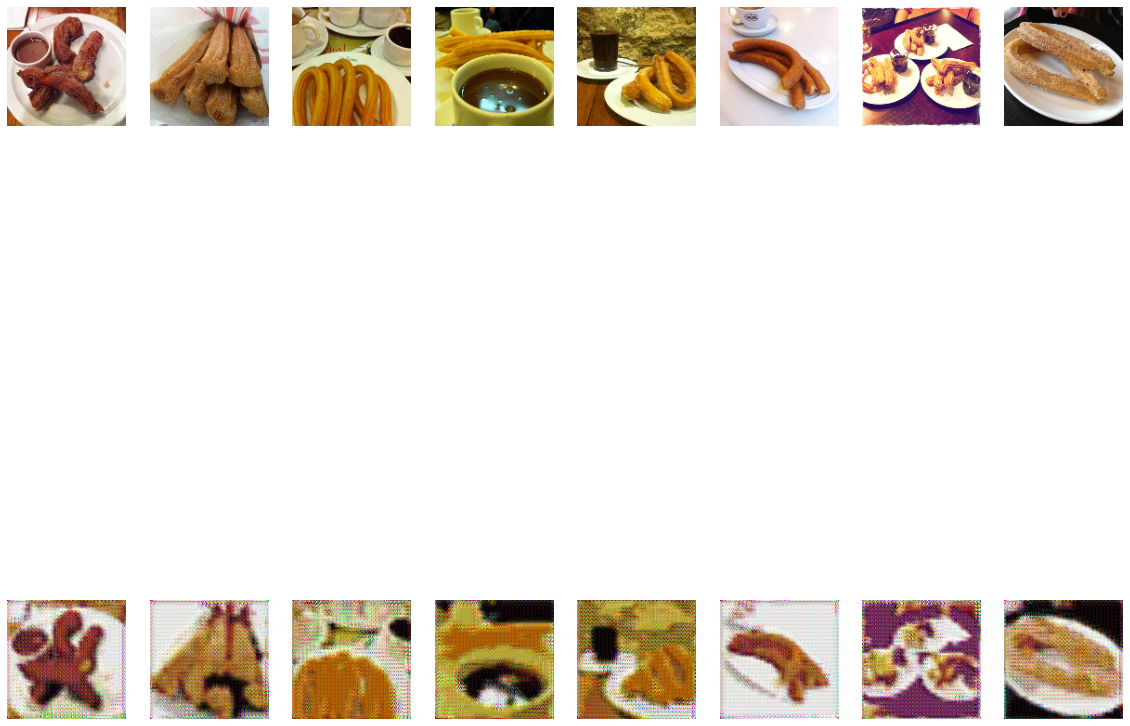

In [71]:
row = 0
fig, ax = plt.subplots(2, 8, figsize=(20, 20))

for i in range(16):
    if i % 8 == 0 and i != 0:
        row += 1
    if row == 0:
        ax[row, i % 8].imshow(data[i % 8].permute(1, 2, 0).cpu().detach().numpy())
    else:
        ax[row, i % 8].imshow(reconstructions[i % 8].permute(1, 2, 0).cpu().detach().numpy())
    ax[row, i % 8].axis('off')